# A First Look to Forecast with Prophet

The main **core** of this notebook is to get a general introduction to the [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) module.

I am going to use these [Dataset](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume) which stores Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

Variables are:
- holiday:     | Categorical | variable for the US National holiday plus regional holiday, Minnesota State Fair.
- temp:        | Continuous  | Average temp in Kelvin.
- rain_1h      | Continuous  | Amount in mm of rain that occurred in the hour.
- snow_1h      | Continuous  | Amount in mm of snow that occurred in the hour.
- clouds_all   | Integer     | Percentage of cloud cover.
- weather_main | Categorical | Short textual description of the current weather.
- weather_description | Categorical | Longer textual description of the current weather
- date_time | Date  | Hour of the data collected in local CST time.
- traffic_volume | integer | Hourly I-94 ATR 301 reported westbound traffic volume

In [1]:
# Modules
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
  # fetch dataset 
metro_interstate_traffic_volume = fetch_ucirepo(id=492) 
  
# data (as pandas dataframes) 
X = metro_interstate_traffic_volume.data.features 
y = metro_interstate_traffic_volume.data.targets 

# Concat dataframes
df = pd.concat([X,y], axis = 1)
# Cast Datetime 

df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date_time'].dt.strftime('%Y-%m-%d'))

In [3]:
print(f'Shape of the DataFrame: {df.shape}')

Shape of the DataFrame: (48204, 10)


In [4]:
def metrics(x, nbr = 0):

    mean = np.round(np.mean(x), nbr)
    min = np.min(x)
    max = np.max(x)

    string_ = f'Mean: {mean} | Min: {min} | Max: {max}'
    
    return string_ 


## Prepare Data for Prophet

Prophet needs (essensially) two columns:
- ds: Date column
- y: Target variable

First date in the dataset: 2012-10-02 00:00:00
First date in the dataset: 2018-09-30 00:00:00
Shape:(1860, 2)


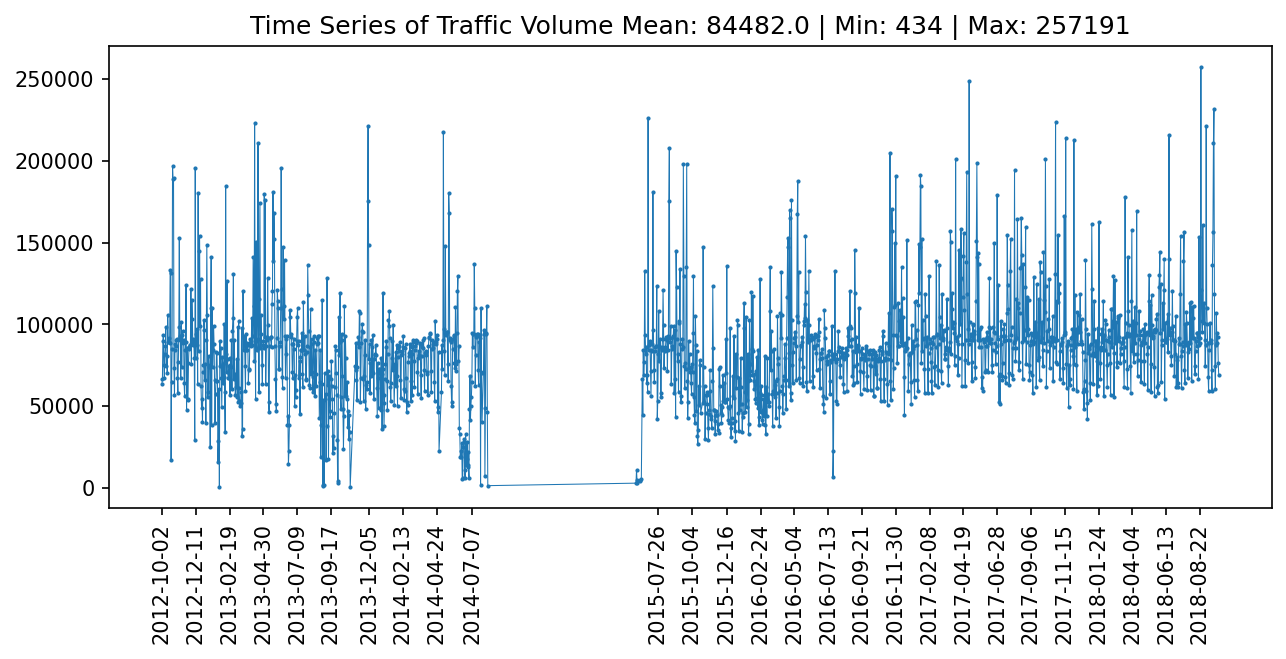

In [8]:
# I am going to group the data in order to have the structure that I need.
t = df.groupby(['date'], as_index = False).agg({'traffic_volume': 'sum'}).rename({'date':'ds', 'traffic_volume' : 'y'}, axis = 1)
t['ds'] = pd.to_datetime(t['ds'])

# Important things in the dataframe
min_date = t['ds'].min()
print(f'First date in the dataset: {min_date}')

max_date = t['ds'].max()
print(f'First date in the dataset: {max_date}')

# Shape of the dataFrame
print(f'Shape:{t.shape}')

add_name = metrics(t['y'].values)

t.set_index(['ds'], inplace = True)

# Plot
fig, ax = plt.subplots(dpi = 150, figsize = (10,4))
plt.title(f'Time Series of Traffic Volume {add_name}')
plt.plot(t['y'], linewidth = 0.5, marker = 'o', markersize = 1)
xticks = t.index[::70] 
plt.xticks(xticks, rotation=90)
plt.show()


In [15]:
t.reset_index()["ds"].diff().max()

Timedelta('307 days 00:00:00')

When visualizing the data, it becomes evident that traffic volume is a strong candidate for time series forecasting. Although the dataset contains no explicit null values, a gap of nearly one year without records can be considered as missing data. This temporal discontinuity may affect time series modeling and should be handled appropriately.

## Trend
In order to obtain the trend of a serie, we have to calculate a Moving Average using a window of period, in order to get this metric, we are going to use the "rolling" function from Pandas. You need to indicate:
- window: Number of days you would like to use to calculate the moving average
- center: If this is True, then Moving Average is calculate using previous and future data.

In [88]:
window = 7
trend = t.rolling(window = window, center = True).mean()

In [95]:
detrended = t - trend
daily_seasonality = detrended.groupby(detrended.index.weekday).mean()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición aditiva
result = seasonal_decompose(t['y'], model='multiplicative', period = 7)  # Aproximadamente un mes

# Gráficos de los componentes
result.plot()
plt.tight_layout()
plt.show()


## A first model using prophet

In [ ]:
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf

model = Prophet()
model.fit(t)

In [ ]:
# Making Predictions
future = model.make_future_dataframe(periods=0)  # Only in the Training set
forecast = model.predict(future)

# Calculamos los residuos
t['resid'] = t['y'] - forecast['yhat']

# Graficamos la ACF de los residuos
plot_acf(t['resid'].dropna(), lags=10)
plt.title("ACF de los residuos de Prophet")
plt.show()